In [2]:
import numpy as np
import scanpy as sp
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import sklearn as sk
from sklearn import svm
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV

seed = 2023 # DO NOT CHANGE!

In [3]:
print(f"sklearn version: {sk.__version__}")
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"scanpy version: {sp.__version__}")

sklearn version: 1.0.1
numpy version: 1.21.3
pandas version: 1.3.4
matplotlib version: 3.4.3
scanpy version: 1.9.1


# Load Data

In [4]:
BMMC = sp.read_h5ad("GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")

In [5]:
print(f"The data has {BMMC.n_obs} observations and {BMMC.n_vars} features.")

The data has 69249 observations and 129921 features.


In [6]:
BMMC

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

# Train/Test Split

We seperate a few donors for test set (best practise)

In [7]:
BMMC.obs.drop_duplicates(subset=["DonorID"], keep='first').reset_index()[["Site","DonorID","DonorAge","DonorBMI","DonorBloodType","DonorRace","Ethnicity","DonorGender","QCMeds","DonorSmoker"]].set_index('DonorID').sort_values(by=['DonorID'])

,Site,DonorAge,DonorBMI,DonorBloodType,DonorRace,Ethnicity,DonorGender,QCMeds,DonorSmoker
DonorID,,,,,,,,,
10886,site1,35,28.6,B+,Asian,NOT HISPANIC OR LATINO,Female,True,Nonsmoker
11466,site3,22,31.5,A+,Asian,NOT HISPANIC OR LATINO,Female,True,Nonsmoker
12710,site2,27,32.1,O+,White,NOT HISPANIC OR LATINO,Male,False,Nonsmoker
13272,site4,35,31.0,O+,Other Race,HISPANIC OR LATINO,Male,False,Nonsmoker
15078,site1,34,24.8,B-,White,HISPANIC OR LATINO,Male,False,Nonsmoker
16710,site2,40,27.8,O+,White,HISPANIC OR LATINO,Female,False,Smoker
18303,site1,33,24.0,O+,Asian,NOT HISPANIC OR LATINO,Male,False,Smoker
19593,site4,31,32.6,A+,Black or African American,NOT HISPANIC OR LATINO,Male,False,Nonsmoker
28045,site3,36,23.8,A+,Other Race,HISPANIC OR LATINO,Female,False,Nonsmoker


69249 samples of 10 donors


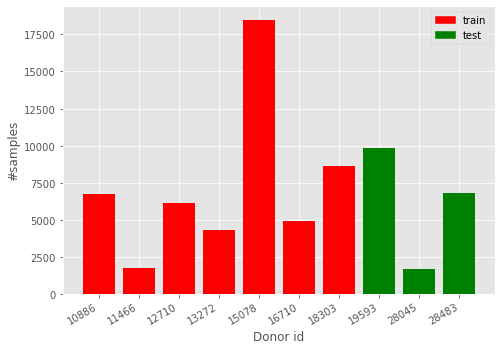

In [8]:
donors, donor_sample_count = np.unique(BMMC.obs['DonorID'], return_counts=True)
color = ['red', 'red', 'red', 'red', 'red', 'red', 'red', 'green', 'green', 'green']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
print(f"{np.sum(donor_sample_count)} samples of {len(donors)} donors")
ax.bar(list(map(str, donors)), donor_sample_count, color=color)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Donor id")
plt.ylabel("#samples")
colors = {'train':'red', 'test':'green'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.show()

In [9]:
test_donors_idx = [19593, 28045, 28483]
test_filter = np.isin(BMMC.obs['DonorID'], test_donors_idx)
train_filter = np.invert(test_filter)

n_train = np.sum(train_filter)
n_test = np.sum(test_filter)
print(f"{n_train} train samples\n{n_test} test samples\n{n_train/(n_train+n_test)*100:.2f}% of samples used for training")

50913 train samples
18336 test samples
73.52% of samples used for training


In [10]:
X_test = BMMC.obsm['ATAC_gene_activity'][test_filter]
X_train = BMMC.obsm['ATAC_gene_activity'][train_filter]

Y_test = BMMC.obs['cell_type'][test_filter]
Y_train = BMMC.obs['cell_type'][train_filter]

In [11]:
Y_train

TAGTTGTCACCCTCAC-1-s1d1     Naive CD20+ B
CTATGGCCATAACGGG-1-s1d1        CD14+ Mono
CCGCACACAGGTTAAA-1-s1d1            CD8+ T
TCATTTGGTAATGGAA-1-s1d1            CD8+ T
ACCACATAGGTGTCCA-1-s1d1        CD16+ Mono
                                ...      
AAACCGCGTTTGAGGC-12-s4d9     CD8+ T naive
TGACTTAAGTTCCCGT-12-s4d9       Lymph prog
GCTGTACCACCGTTCC-12-s4d9           CD8+ T
ACACTTGCAACTAGAA-12-s4d9             cDC2
CACTTAAAGTCTGGGC-12-s4d9    Naive CD20+ B
Name: cell_type, Length: 50913, dtype: category
Categories (22, object): ['B1 B', 'CD4+ T activated', 'CD4+ T naive', 'CD8+ T', ..., 'Proerythroblast', 'Transitional B', 'cDC2', 'pDC']

In [12]:
train_donors = BMMC.obs[train_filter]['DonorID']

# Data visualistion

In [13]:
cell_types = np.unique(BMMC.obs['cell_type'])
print(cell_types)

['B1 B' 'CD14+ Mono' 'CD16+ Mono' 'CD4+ T activated' 'CD4+ T naive'
 'CD8+ T' 'CD8+ T naive' 'Erythroblast' 'G/M prog' 'HSC'
 'ID2-hi myeloid prog' 'ILC' 'Lymph prog' 'MK/E prog' 'NK' 'Naive CD20+ B'
 'Normoblast' 'Plasma cell' 'Proerythroblast' 'Transitional B' 'cDC2'
 'pDC']


50913 samples of 22 cells


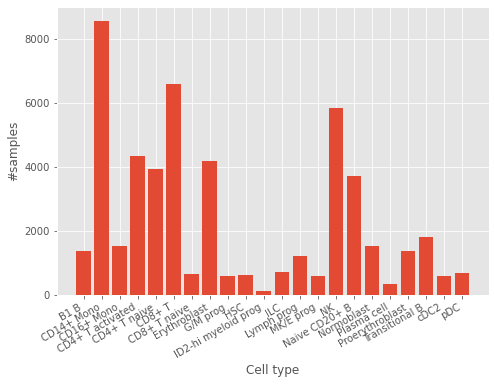

In [15]:
cell_types = np.unique(BMMC.obs['cell_type'])
cell_types_sorted = sorted(cell_types)


cells, counts = np.unique(Y_train, return_counts=True)
print(f"{np.sum(counts)} samples of {len(cells)} cells")
for missing_celltype in set(cell_types) - set(cells):
    cells = np.append(cells, missing_celltype)
    counts = np.append(counts, 0)

sorted_counts = counts[[np.where(np.isin(cells, c))[0][0] for c in cell_types_sorted]]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(cell_types_sorted, sorted_counts)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Cell type")
plt.ylabel("#samples")
plt.show()

In [19]:
X_train

<50913x19039 sparse matrix of type '<class 'numpy.float32'>'
	with 268039283 stored elements in Compressed Sparse Column format>

In [20]:
print(f"The sparsity of the train matrix is {(1 - X_train.nnz / (X_train.shape[0] * X_train.shape[1])) * 100:.2f}%")

The sparsity of the train matrix is 72.35%


# Model Training

In [23]:
n_folds = 5 # change?

cv = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state = seed)

param_grid = {
    'C': [10**x for x in np.arange(-2, 1.1, 0.5)]
}

lsvc = svm.LinearSVC()
gridsearch = GridSearchCV(lsvc, param_grid, n_jobs=-1, cv=cv, verbose=5, 
                          return_train_score=True)

gridsearch.fit(X_train, Y_train, groups=train_donors)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ........C=0.01;, score=(train=1.000, test=0.773) total time= 4.8min
[CV 2/5] END ........C=0.01;, score=(train=1.000, test=0.739) total time= 4.8min
[CV 3/5] END ........C=0.01;, score=(train=1.000, test=0.674) total time= 5.1min
[CV 4/5] END ........C=0.01;, score=(train=1.000, test=0.784) total time= 6.6min
[CV 5/5] END ........C=0.01;, score=(train=1.000, test=0.733) total time= 4.6min
[CV 1/5] END C=0.03162277660168379;, score=(train=1.000, test=0.772) total time= 5.0min
[CV 2/5] END C=0.03162277660168379;, score=(train=1.000, test=0.736) total time= 5.1min
[CV 3/5] END C=0.03162277660168379;, score=(train=1.000, test=0.674) total time= 5.1min
[CV 4/5] END C=0.03162277660168379;, score=(train=1.000, test=0.778) total time= 7.7min
[CV 5/5] END C=0.03162277660168379;, score=(train=1.000, test=0.730) total time= 5.5min
[CV 1/5] END .........C=0.1;, score=(train=1.000, test=0.771) total time= 5.3min
[CV 2/5] END .

GridSearchCV(cv=StratifiedGroupKFold(n_splits=5, random_state=2023, shuffle=True),
             estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.03162277660168379, 0.1,
                               0.31622776601683794, 1.0, 3.1622776601683795,
                               10.0]},
             return_train_score=True, verbose=5)

In [24]:
results = gridsearch.cv_results_
train_score = results['mean_train_score'][gridsearch.best_index_]
validation_score = results['mean_test_score'][gridsearch.best_index_]

print(f'Average training accuracy across folds: {train_score:.3}')
print(f'Average validation accuracy across folds: {validation_score:.3}')

print(f'Best hyperparams: {gridsearch.best_params_}')

Average training accuracy across folds: 1.0
Average validation accuracy across folds: 0.741
Best hyperparams: {'C': 0.01}


In [25]:
# save best model
with open('lsvm_atac.pkl','wb') as f:
    pickle.dump(gridsearch.best_estimator_,f)